In [1]:
# %pip install kagglehub --quiet
import kagglehub
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.__version__, np.__version__

('2.19.0', '1.26.4')

# Frame The Problem And Look At The Big Picture

1. **Define the objective in business terms**:

   The Bronx Zoo in New York has engaged us to enhance their animal tracking capabilities. The zoo's operating director aims to update their existing image database of zoo animals in order to develop a system that can predict whether an animal is in its designated pen—eliminating the need for manual checks.

2. **How will your solution be used**:

   Our solution will be used to determine whether each animal is in its correct pen. The model will be run once daily to confirm that all animals have successfully returned to their enclosures by the end of the day.

3. **Current solutions/workarounds**:

   - **Manual animal species tagging**: Biologists will look at a animal and inspect it to make sure that it is sent to the right enclosure.

4. **Problem framing**:

   - **Supervised learning**: We have labeled data (pictures with labels).
   - **Multi-class classification**: The task is to classify pictures of animals into the 10 respective classes.
   - **Use case**: The system will be used in the Bronx zoo to classify animals to make sure they go to the right enclosure.

5. **Performance measurement**:

   - **Precision (macro)**: We are using precision (macro) because we are highly concerned that if we miss classify a animal like a bobcat and a coyote and they end up in the same enclosure could mean very big issues for the zoo and animals.
   - **Success criteria**: A precision of 80% would be acceptable in this problem because the workers would get a general idea and a expert could give the animal classification a once over to ensure, which would keep the process efficient.

6. **Comparable problems**:

   - **Computer Vision**: most if not all of the comparable problems to our business problem are all some sort of computer vision classification. Like intel image classification, and even things like urban sound 8k because they train on spectograms.

7. **Human expertise availability**:

   - **Biology experts**: While biology experts can accuracy classify animals to make sure they are being directed to the right enclosure but this takes a large amount of time, our aim is to shorten this process by providing a service to classify the animals to the correct enclosures only requiring a once over from the expert.
   - **Availability**: There is available expertise in the bronx zoo, this expertise include people that can accurately classify animals to the correct enclosures.

8. **Manual solution process**:

   A human would:
      Ask experts in the field to classify these animals, this way the animals would be correctly classified into the correct enclosures.

Get the Data
============

1. **List the data you need and how much you need:**
    - Images of animals across 10 categories: dog, horse, elephant, butterfly, chicken, cat, cow, sheep, spider, squirrel.
    - The dataset contains ~28,000 images distributed across these 10 categories
2. **Find and document where you can get that data:**
    - Source: Kaggle Dataset - Animals-10
    - Method of Access: Download using kagglehub.dataset_download("alessiocorrado99/animals10") in the provided script.
3. **Get access authorizations**:
   - Find the dataset
   - Download the dataset 

4. **Create a workspace**: This notebook.

5. **Get the data**: 
    - Downloads the dataset.
    - Moves and organizes images into the ./data directory.
    - Translates folder names from Italian to English.
6. **Convert the data to a format you can easily manipulate**:
   - Loads file paths and associated labels into a pandas.DataFrame.
   - Splits data into train/test using train_test_split with stratification.
   - Returns data ready for training ML models.

### Downloading the data

This script downloads the Animals10 dataset and organizes it into a flat directory structure. It renames the Italian class folder names to English using a translation dictionary. Finally, it creates a Pandas DataFrame with image file paths and their corresponding labels for training.

In [3]:
def download_data():
    path = kagglehub.dataset_download("alessiocorrado99/animals10")

    translate = {
        "cane": "dog",
        "cavallo": "horse",
        "elefante": "elephant",
        "farfalla": "butterfly",
        "gallina": "chicken",
        "gatto": "cat",
        "mucca": "cow",
        "pecora": "sheep",
        "ragno": "spider",
        "scoiattolo": "squirrel",
    }

    os.makedirs("./data", exist_ok=True)
    shutil.move(path, "./data")
    for directory in os.listdir("./data/2/raw-img"):
        full_path = os.path.join("./data/2/raw-img", directory)
        if os.path.isdir(full_path):
            shutil.move(full_path, "./data")
    shutil.rmtree("./data/2")

    for folder in os.listdir("./data"):
        full_path = os.path.join("./data", folder)
        if os.path.isdir(full_path):
            new_folder_name = translate.get(folder, folder)
            new_full_path = os.path.join("./data", new_folder_name)
            if new_full_path != full_path:
                os.rename(full_path, new_full_path)

    print("Dataset downloaded and organized in './data' directory.")

def load_meta_data():
    file_names = []
    labels = []

    for folder in os.listdir("./data"):
        for file in os.listdir(os.path.join("./data", folder)):
            full_path = os.path.join("./data", folder, file)
            if os.path.isfile(full_path):
                file_names.append(full_path)
                labels.append(folder)

    meta_data = pd.DataFrame({
        'file_path': file_names,
        'label': labels
    })
    meta_data['label'] = meta_data['label'].astype('category')
    return train_test_split(meta_data, test_size=0.15, random_state=42, stratify=meta_data['label'])


This code  downloads a dataset of animal images from Kaggle and gets it ready for machine learning. It's pretty straightforward once you understand what's happening:
The download_data() function:

- Grabs an animal image dataset from Kaggle using the kagglehub library
- Creates a dictionary to translate Italian animal names to English (like "cane" → "dog")
- Makes a data folder and moves everything there
- Reorganizes the file structure by moving all the animal folders out of the nested directories
- Cleans up by deleting unnecessary folders
- Renames all the folders from Italian to English
- Lets you know it's done with a print statement

The load_meta_data() function:

- Goes through all the image files in the data directory
- Creates lists of file paths and their corresponding labels (which animal they are)
- Puts this info into a pandas DataFrame
- Converts the label column to a categorical data type (better for machine learning)
- Splits the data into training and testing sets (85% training, 15% testing)
- Makes sure the split maintains the same proportion of each animal class using stratification
- Returns both datasets for use in model training

In [4]:
# download_data()
train_set, test_set = load_meta_data()
train_set, pred_set = train_test_split(train_set, test_size=0.1765, random_state=42, stratify=train_set['label'])
train_set.head(10)

,file_path,label
16390,./data/chicken/174.jpeg,chicken
18547,./data/horse/OIP-78a5INoBO4OFpvSPi1_GbAHaEj.jpeg,horse
18974,./data/horse/OIP-9AdNcpetffoqoU56p_FVPgEsDS.jpeg,horse
15046,./data/spider/OIP-dcF8wNkNTBL8lZ6uepPgtwHaE7.jpeg,spider
17232,./data/chicken/14.jpeg,chicken
13183,./data/spider/OIP-Cp0kCe19iH7dtRONiGPK6QHaFj.jpeg,spider
20638,./data/horse/OIP-V5POyTuUINe8RmYF2f8A7QHaKD.jpeg,horse
21864,./data/squirrel/OIP-bqvV9Aot2ZsDcWK1w84HZQHaE8...,squirrel
18509,./data/horse/OIP-YCqlH_06v7d1CgT10svXGQHaEj.jpeg,horse
6570,./data/dog/OIP-_dBx5gv5hTQ9z0yu8F6VcQHaFj.jpeg,dog


The code loads animal image metadata and splits it twice: first into training and test sets, then further dividing the training data into proper training and validation portions. The first 10 rows of the final training set are shown verification training.

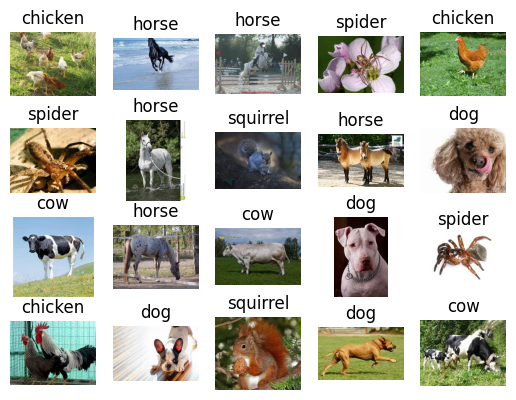

In [55]:
for i in range(20):
    img_path, label = train_set.iloc[i]
    img = plt.imread(img_path)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

- These are our pictures before using the Tensorflow generators for augmentation.
- Here we see some pictures are different sizes from other so we are going to have to resize them for consistent number of features.
- we can resize / pad in the Tensorflow pipeline.

In [12]:
train_set["label"].value_counts() / len(train_set)

label
dog          0.185713
spider       0.184185
chicken      0.118315
horse        0.100196
butterfly    0.080659
cow          0.071273
squirrel     0.071164
sheep        0.069526
cat          0.063742
elephant     0.055228
Name: count, dtype: float64

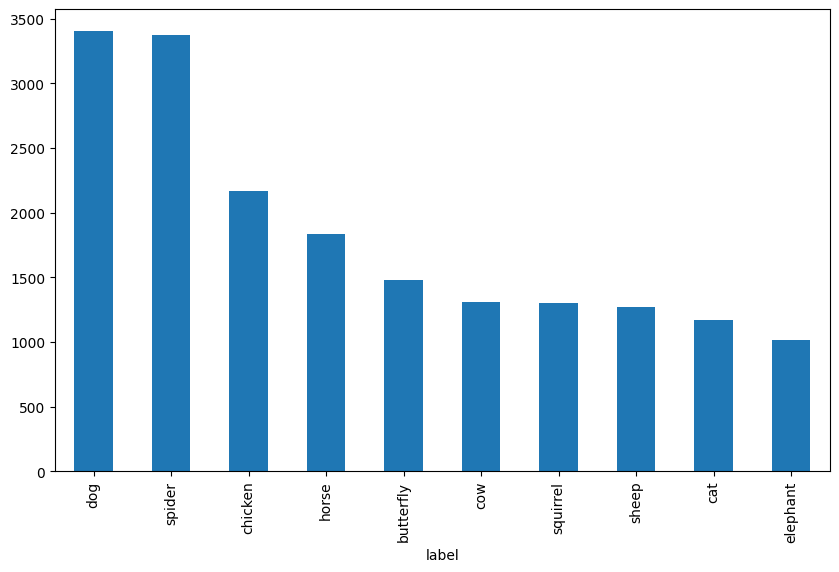

In [5]:
train_set["label"].value_counts().plot(kind='bar', figsize=(10, 6));

- The last two cells show a percentages and a histogram of the classes
- Unbalanced class distribution so since we are using precision we must use the macro average version of our metric where applicable.

In [56]:
def create_data_generators(train_set, pred_set, test_set, img_size=(300, 300), batch_size=32):
    def pad_and_rescale(image):
        image = tf.image.resize_with_pad(image, target_height=img_size[0], target_width=img_size[1])
        image = image / 255.0
        return image
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=pad_and_rescale,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=pad_and_rescale
    )

    pred_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=pad_and_rescale
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_set,
        directory=".",
        x_col="file_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    pred_generator = pred_datagen.flow_from_dataframe(
        dataframe=pred_set,
        directory=".",
        x_col="file_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_set,
        directory=".",
        x_col="file_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    return train_generator, pred_generator, test_generator
train_generator, pred_generator, test_generator = create_data_generators(train_set, pred_set, test_set)

Found 18324 validated image filenames belonging to 10 classes.
Found 3928 validated image filenames belonging to 10 classes.
Found 3927 validated image filenames belonging to 10 classes.


This function creates three specialized data generators for machine learning:

Training generator: Applies various image augmentations (rotations, shifts, zooms, flips) to artificially expand the dataset and improve model generalization
Validation and test generators: Only standardize images without augmentation for proper evaluation

All generators:

Load images in batches from their respective datasets
Resize images to 300×300 pixels while maintaining aspect ratio
Normalize pixel values to 0-1 range
Set up categorical labels for multi-class classification

Special configuration:

Test generator doesn't shuffle data, ensuring predictions maintain their original order

- Here we are creating preprocessing pipelines for the images to go into the model, the train set images are augmented to reduce overfitting.

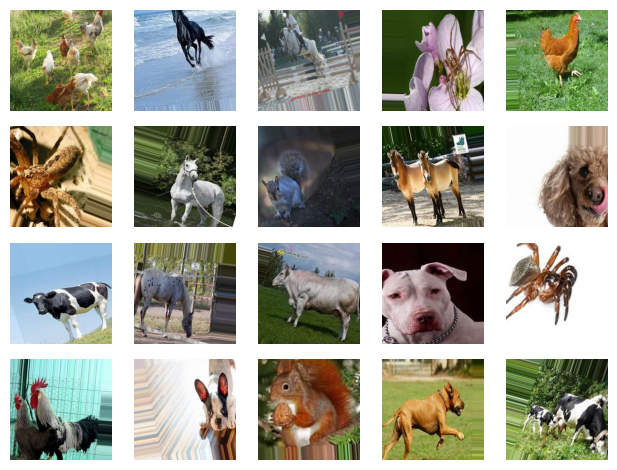

In [57]:
images_batch, labels_batch = next(train_generator)
for i in range(min(20, len(images_batch))):
    plt.subplot(4, 5, i+1)
    img = images_batch[i]
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8)
    
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

- Our pictures after running through the Tensorflow image generators where we augment the pictures and make sure every image is the same size.
- The test set is in the same image generator format but not augmented because this makes no sense instead we just make sure that the photos are in the correct size format and rescaled.

In [6]:
# downsampling the data for short listing
train = train_set.sample(frac=0.3, random_state=42)
train, pred = train_test_split(train, test_size=0.3, random_state=42, stratify=train['label'])
train_gen, _, pred_gen = create_data_generators(train, pred_set, pred)
del train, pred

Found 3847 validated image filenames belonging to 10 classes.
Found 3928 validated image filenames belonging to 10 classes.
Found 1650 validated image filenames belonging to 10 classes.


In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def generator_to_dataframe(generator, max_batches=None):
    num_samples = generator.samples
    batch_size = generator.batch_size
    num_batches = int(np.ceil(num_samples / batch_size))
    if max_batches is not None:
        num_batches = min(num_batches, max_batches)
    generator.reset()
    all_images = []
    all_labels = []
    for i in tqdm(range(num_batches)):
        batch_images, batch_labels = next(generator)
        all_images.append(batch_images)
        all_labels.append(batch_labels)

    images_array = np.vstack(all_images)
    labels_array = np.vstack(all_labels)
    images_array = images_array[:num_samples]
    labels_array = labels_array[:num_samples]

    image_shape = images_array.shape[1:]
    flattened_dim = np.prod(image_shape)
    flat_images = images_array.reshape(images_array.shape[0], flattened_dim)
    del images_array

    image_cols = [f'pixel_{i}' for i in range(flattened_dim)]
    class_names = list(generator.class_indices.keys())

    labels = [class_names[np.argmax(label)] for label in labels_array]
    label_df = pd.DataFrame({'label': labels})
    image_df = pd.DataFrame(flat_images, columns=image_cols)
    del flat_images
    result_df = pd.concat([image_df, label_df], axis=1)
    result_df['original_shape'] = str(image_shape)
    result_df['predicted_class'] = np.argmax(labels_array, axis=1)
    result_df['predicted_class_name'] = result_df['predicted_class'].apply(
        lambda x: class_names[x]
    )
    return result_df

This function generator_to_dataframe converts image data from a generator (typically used in deep learning frameworks like Keras) into a pandas DataFrame. It:

Processes batches of images and labels from a data generator
Flattens the images (converting 2D/3D images into 1D arrays)
Creates a DataFrame containing:

All pixel values (as separate columns)
Original labels
Information about the original image shape
Predicted class indices and names



This is useful for converting image datasets into tabular format for easier analysis, visualization, or use with traditional machine learning algorithms that require tabular data.

In [8]:
train_df = generator_to_dataframe(train_gen)
X_train = train_df.drop(columns=['label', 'original_shape', 'predicted_class', 'predicted_class_name'])
y_train = train_df['label']
del train_df
pred_df = generator_to_dataframe(pred_gen)
X_pred = pred_df.drop(columns=['label', 'original_shape', 'predicted_class', 'predicted_class_name'])
y_pred = pred_df['label']
del pred_df

100%|██████████| 52/52 [00:03<00:00, 13.22it/s]


In [9]:
X_train.columns

Index(['pixel_0', 'pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5',
       'pixel_6', 'pixel_7', 'pixel_8', 'pixel_9',
       ...
       'pixel_269990', 'pixel_269991', 'pixel_269992', 'pixel_269993',
       'pixel_269994', 'pixel_269995', 'pixel_269996', 'pixel_269997',
       'pixel_269998', 'pixel_269999'],
      dtype='object', length=270000)

In [10]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

models = {
    "RandomForestClassifier": RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=20,
        n_jobs=-1, 
        verbose=0,
        max_features='sqrt'
    ),
    
    "LogisticRegression": LogisticRegression(
        max_iter=500,
        solver='saga',
        tol=0.01,
        C=1.0,
        n_jobs=-1
    ),
    
    "KNeighborsClassifier": KNeighborsClassifier(
        n_neighbors=5,
        algorithm='kd_tree',
        leaf_size=40,
        n_jobs=-1
    ),
    
    "DecisionTreeClassifier": DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        max_features='sqrt'
    ),
    
    "AdaBoostClassifier": AdaBoostClassifier(
        n_estimators=50,
        learning_rate=1.0
    ),
    
    "ExtraTreesClassifier": ExtraTreesClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=20,
        n_jobs=-1,
        max_features='sqrt'
    )
}

lc = LabelEncoder()
y_train = lc.fit_transform(y_train)
y_pred = lc.transform(y_pred)

for name, model in models.items():
    print(f"Fitting on model: {name}")
    model.fit(X_train, y_train)
    print(f"Predicting on model: {name}")
    y_predicted = model.predict(X_pred)
    print(f"Evaluating model: {name}")
    print(f"Accuracy: {accuracy_score(y_pred, y_predicted)}")
    print(f"Precision Score: {precision_score(y_pred, y_predicted, average='macro')}")
    print(f"Recall Score: {recall_score(y_pred, y_predicted, average='macro')}")

Fitting on model: RandomForestClassifier
Predicting on model: RandomForestClassifier
Evaluating model: RandomForestClassifier
Accuracy: 0.2727272727272727
Precision Score: 0.21456554485568793
Recall Score: 0.18544315928099567
Fitting on model: LogisticRegression


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Predicting on model: LogisticRegression
Evaluating model: LogisticRegression
Accuracy: 0.2109090909090909
Precision Score: 0.16959307095208329
Recall Score: 0.16789564979204874
Fitting on model: KNeighborsClassifier
Predicting on model: KNeighborsClassifier
Evaluating model: KNeighborsClassifier
Accuracy: 0.2018181818181818
Precision Score: 0.1422188937721866
Recall Score: 0.13732835377200697
Fitting on model: DecisionTreeClassifier
Predicting on model: DecisionTreeClassifier
Evaluating model: DecisionTreeClassifier
Accuracy: 0.20363636363636364
Precision Score: 0.1640962371589244
Recall Score: 0.15644751842455848
Fitting on model: AdaBoostClassifier


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Predicting on model: AdaBoostClassifier
Evaluating model: AdaBoostClassifier
Accuracy: 0.19515151515151516
Precision Score: 0.1818840188054847
Recall Score: 0.16776695698306238
Fitting on model: ExtraTreesClassifier
Predicting on model: ExtraTreesClassifier
Evaluating model: ExtraTreesClassifier
Accuracy: 0.27636363636363637
Precision Score: 0.3118856100284516
Recall Score: 0.18289384118567478


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This code framework for training and evaluating multiple classification models on a common dataset.Leverages scikit-learn and XGBoost and configures each with optimized hyperparameters for comparative analysis.
The framework follows a structured workflow:

Model Selection: Incorporates diverse algorithms including ensemble methods (Random Forest, AdaBoost, Extra Trees), linear models (Logistic Regression), and instance-based approaches (K-Nearest Neighbors)
Data Preparation: Handles categorical target encoding through LabelEncoder
Model Training: Systematically trains each classifier on the training dataset
Prediction Generation: Applies trained models to test data
Performance Evaluation: Assesses model effectiveness through multiple metrics (accuracy, precision, recall)

- Wow... Not surprising at all definitely using a neural network here.

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(300, 300, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

This code is a neural network (CNN) using TensorFlow's Keras API. The model includes:

4 convolutional layers (with 32, 64, 128, and 256 filters, respectively), each followed by batch normalization and max-pooling.

Flattening layer to convert the 2D outputs into a 1D vector.

3 dense layers, with 256 and 128 neurons and a final 10-neuron output layer (softmax activation for multi-class classification).

It then compiles the model with the Adam optimizer (learning rate = 0.0005), categorical cross-entropy loss (for multi-class classification), and accuracy as the evaluation metric.

In [49]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 300, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    21,233,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,658,442 (82.62 MB)

 Trainable params: 21,657,482 (82.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [50]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=pred_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')
    ]
)

Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1383s 2s/step - accuracy: 0.2685 - loss: 3.3956 - val_accuracy: 0.4341 - val_loss: 1.6735
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.4328 - loss: 1.6515 - val_accuracy: 0.4433 - val_loss: 1.6440
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1330s 2s/step - accuracy: 0.5077 - loss: 1.4143 - val_accuracy: 0.5302 - val_loss: 1.3384
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1331s 2s/step - accuracy: 0.5720 - loss: 1.2412 - val_accuracy: 0.5773 - val_loss: 1.2977
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1335s 2s/step - accuracy: 0.6194 - loss: 1.1080 - val_accuracy: 0.5976 - val_loss: 1.1741
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.6491 - loss: 1.0303 - val_accuracy: 0.6663 - val_loss: 1.0271
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.6790 - loss: 0.9451 - val_accuracy: 0.4446 - val_loss: 1.8207
Epoch 8/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1329s 2s/step - accuracy: 0.6863 - loss: 0.9106 - 

- Hilariously bad its basically just guessing that it is always going to be a spider, but on the actual spider it thinks it is going to be a butterfly.
- The percentage values is the confidence value so top right dog with a prediction of spider 82.01% means that the model is 82.01% certain that it is a spider.
- definitely some modifications we need to make to the model.

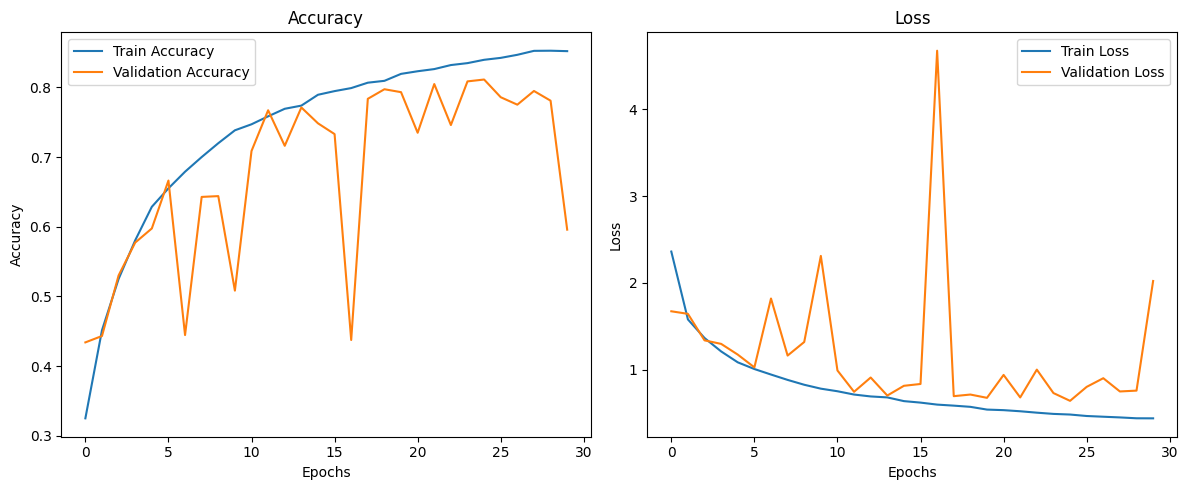

In [57]:
# plotting the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

- Graph of the train and validation, accuracy and loss over epochs.

- Honestly pretty good
- Expected a lot worse we are going to have to try some more models or try a grid search but honestly pretty good.

```json
'param_grid' = {
    'optimizer': ['adam', 'sgd'],
    'batch_size': [16, 32],
    'epochs': [10, 20]
}
```

In [11]:
def create_model(optimizer='adam'):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(300, 300, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['precision', 'recall', 'accuracy']
    )
    return model

for optimizer in ['adam', 'sgd']:
    for batch_size in [16, 32]:
        for epochs in [10, 20]:
            print(f"Training with: {optimizer}, {batch_size}, {epochs}")

            model = create_model(optimizer=optimizer)

            history = model.fit(
                train_generator,
                epochs=epochs,
                validation_data=pred_generator,
                steps_per_epoch=len(train_generator),
                validation_steps=len(test_generator),
                batch_size=batch_size
            )
            test_loss, test_precision, test_recall, test_accuracy = model.evaluate(test_generator)
            print(f"Params: {optimizer}, {batch_size}, {epochs}")
            print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Precision: {test_precision * 100:.2f}%, Test Recall: {test_recall * 100:.2f}%, Test Loss: {test_loss:.4f}")
            print("-" * 50)

Training with: adam, 16, 10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 1139s 2s/step - accuracy: 0.2172 - loss: 5.5640 - precision: 0.2627 - recall: 0.1102 - val_accuracy: 0.3419 - val_loss: 1.9342 - val_precision: 0.5445 - val_recall: 0.0619
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 2499s 4s/step - accuracy: 0.3493 - loss: 1.8425 - precision: 0.6049 - recall: 0.1164 - val_accuracy: 0.4771 - val_loss: 1.5517 - val_precision: 0.6239 - val_recall: 0.3361
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 1148s 2s/step - accuracy: 0.4604 - loss: 1.5724 - precision: 0.6642 - recall: 0.2406 - val_accuracy: 0.3359 - val_loss: 2.3637 - val_precision: 0.4586 - val_recall: 0.2498
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 1110s 2s/step - accuracy: 0.5161 - loss: 1.3991 - precision: 0.7055 - recall: 0.3291 - val_accuracy: 0.5084 - val_loss: 1.4300 - val_precision: 0.6668 - val_recall: 0.3260
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 1165s 2s/step - accuracy: 0.5653 - loss: 1.2496 - precision: 0.7332 - recall: 0.4007 - val_accuracy: 0.4139 - va

- This code makes a CNN model that looks at images and tries to classify them into 10 groups. It has a bunch of layers to find patterns and shrink the data down. Then it tests different settings (like optimizer, batch size, and number of epochs) to see which one trains the model the best. After training, it checks how good the model is and prints out the results.
- Our grid search points to the following param grid being the best:
```python
param_grid = {
    'optimizer': 'sgd',
    'batch_size': 32,
    'epochs': 20
}
Test Accuracy: 74.06%, Test Precision: 80.74%, Test Recall: 69.25%, Test Loss: 0.7895
```

Now we can take these parameters and increase our epochs for our final model.

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(300, 300, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['precision', 'recall', 'accuracy']
)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=pred_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(pred_generator),
    batch_size=32
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 896s 2s/step - accuracy: 0.2974 - loss: 2.1801 - precision: 0.4513 - recall: 0.1066 - val_accuracy: 0.4397 - val_loss: 1.6204 - val_precision: 0.6393 - val_recall: 0.2144
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 902s 2s/step - accuracy: 0.4524 - loss: 1.5973 - precision: 0.6570 - recall: 0.2516 - val_accuracy: 0.5122 - val_loss: 1.4127 - val_precision: 0.6508 - val_recall: 0.3750
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 902s 2s/step - accuracy: 0.4889 - loss: 1.4852 - precision: 0.6717 - recall: 0.2987 - val_accuracy: 0.5244 - val_loss: 1.3712 - val_precision: 0.6806 - val_recall: 0.3635
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 910s 2s/step - accuracy: 0.5246 - loss: 1.3774 - precision: 0.6960 - recall: 0.3540 - val_accuracy: 0.5850 - val_loss: 1.2079 - val_precision: 0.7195 - val_recall: 0.4414
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 895s 2s/step - accuracy: 0.5600 - loss: 1.2737 - precision: 0.7237 - recall: 0.4094 - val_accuracy: 0.6105 - val_los

Huge plateau, very slow metric improvement in the later epochs but none the less improvement was seen.

In [33]:
test_loss, test_precision, test_recall, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Precision: {test_precision * 100:.2f}%, Test Recall: {test_recall * 100:.2f}%, Test Loss: {test_loss:.4f}")

123/123 ━━━━━━━━━━━━━━━━━━━━ 40s 325ms/step - accuracy: 0.8096 - loss: 0.6803 - precision: 0.8371 - recall: 0.7891
Test Accuracy: 79.91%, Test Precision: 82.99%, Test Recall: 77.92%, Test Loss: 0.6946


- pretty good we are surpassing our goal with a 80% precision needed.

In [39]:
model.save("animal_classifier_model.keras")

- Here we are saving our model to a `.keras` file so we can reload it just in case.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 40s 324ms/step


Text(50.722222222222214, 0.5, 'True Class')

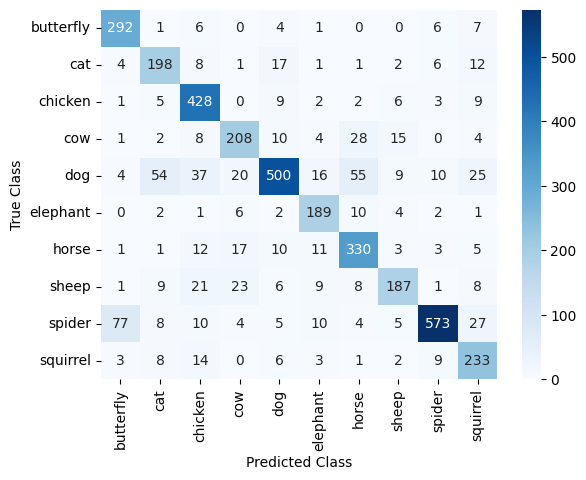

In [46]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = test_generator.labels
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys());
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

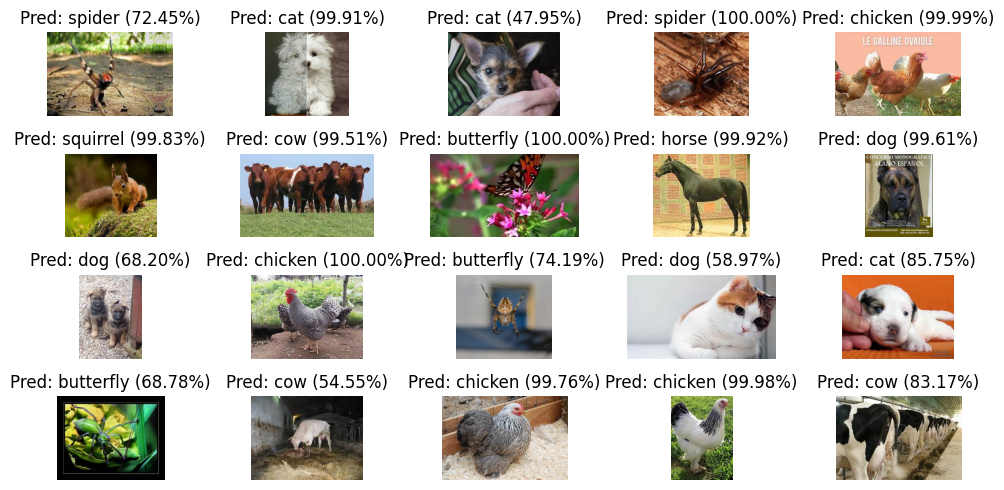

In [54]:
import matplotlib.image as mpimg
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 5))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    img = mpimg.imread(test_generator.filepaths[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_names[np.argmax(y_pred_probs[i])]} ({y_pred_probs[i][np.argmax(y_pred_probs[i])]*100:.2f}%)")
plt.tight_layout()

Percentages are Confidence values.

Yes! Looks good I understand how the model can mis-classify the dog on the top row

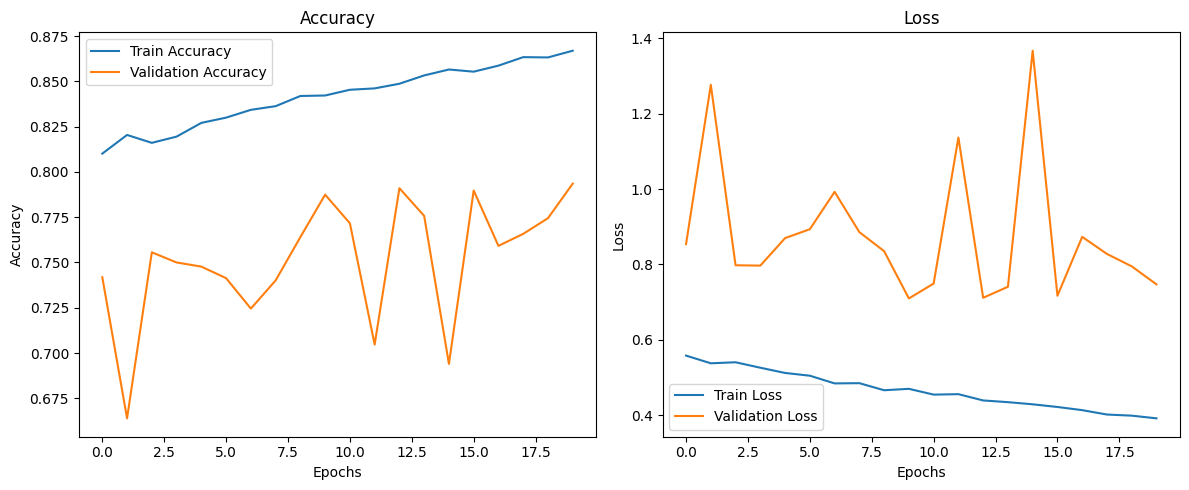

In [ ]:
# plotting the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

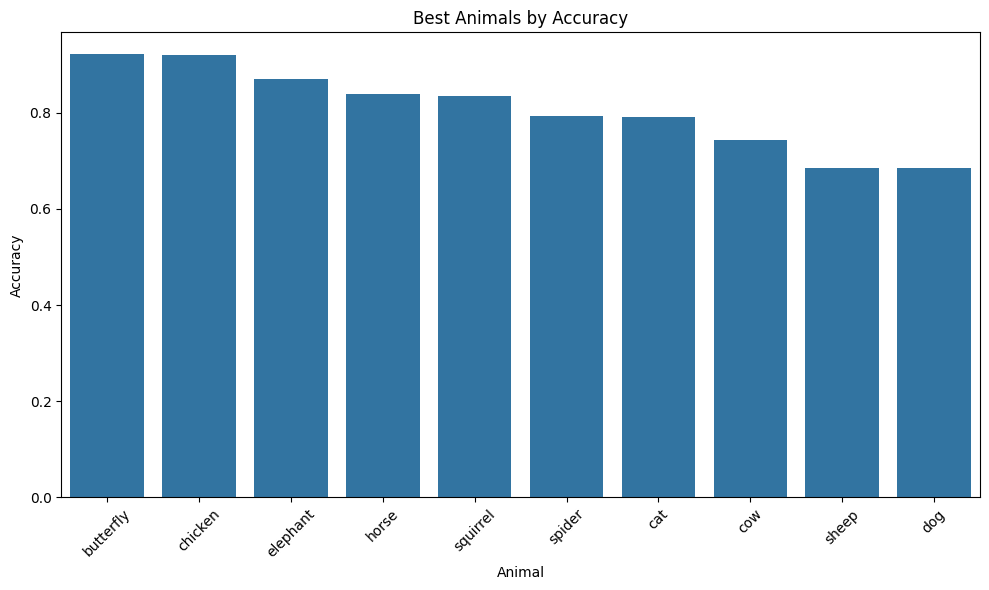

In [49]:
# plotting the best animals by accuracy
best_animals = pd.DataFrame({
    'animal': test_generator.class_indices.keys(),
    'accuracy': np.diag(cm) / np.sum(cm, axis=1)
}).sort_values(by='accuracy', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='animal', y='accuracy', data=best_animals)
plt.title('Best Animals by Accuracy')
plt.xlabel('Animal')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()